# Simple Spark Bootstrap Regression Example

This is a quick demonstration of using Spark as an engine for running simulations across a grid. 

This example will execute a basic OLS regression on a familiar dataset from R's data examples, namely the eruption data about Old Faithful at Yellowstone National Park, Wyoming, USA. 

We will obtain the point estimates for the regression of 

$$\textrm{duration} = \beta_0 + \beta_1\textrm{waiting} + \epsilon$$

using standard OLS regression, and then use residual bootstrapping to estimate the variance in the $\beta$ estimates.

The bootstrap will be created first on a single core Python instance and compared to output from a standard Python regression library, statsmodels.

After confirming that the single-core bootstrap reproduces the standard OLS variance estimates, we will run the exact same bootstrap procedure through Spark and compare results and timing to the single-instance version.


## First define the necessary regression function

In [1]:
from __future__ import division
import numpy as np
#from pyspark import SparkContext   # This is only needed for code which is run outside the Spark IPython notebook.

try:
    %matplotlib inline
except:
    pass


# create some functions to run the regression:
def run_regression(X,Y):
    '''Simple function to execute linear regression'''
    # Set up matrix values for regression execution:
    XTX = np.dot(X.T, X)    # X'X
    XTY = np.dot(X.T, Y)    # X'Y

    # Linear-algebra solve for Beta in more numerically efficient way:
    Beta = np.linalg.solve(XTX, XTY)
    return Beta

def single_bootstrap(X,Y,seed=None):
    # Get Beta_hat
    Beta_hat = run_regression(X,Y)

    # Get eps_hat:
    eps_hat = Y - np.dot(X, Beta_hat)

    # Now do one bootstrap resampling:
    # Create random number generator:
    RNG = np.random.RandomState(seed)
    Nobs = eps_hat.shape[0]

    # Resample the eps_hat:
    epsilon_resample_index = RNG.randint(low=0,high=Nobs,size=Nobs)
    eps_hat_squiggle = np.array( [ eps_hat[epsilon_resample_index, 0] ] ).T

    # Create new Y_hat_squiggle:
    Y_hat_squiggle = np.dot(X, Beta_hat) + eps_hat_squiggle

    # Re-estimate Beta_hat using Y_hat_squiggle and X:
    Beta_hat_squiggle = run_regression(X,Y_hat_squiggle)

    return Beta_hat_squiggle


Load Geyser data exported from R's MASS public data libraries
Scatterplot of duration and waiting:


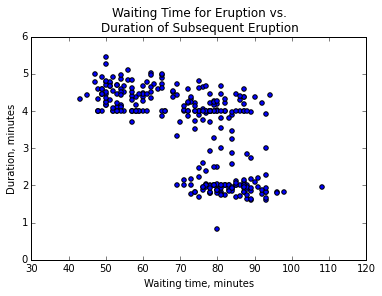

\Histograms of duration and waiting:


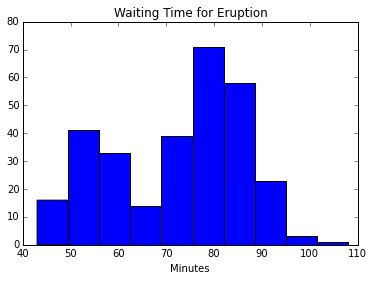

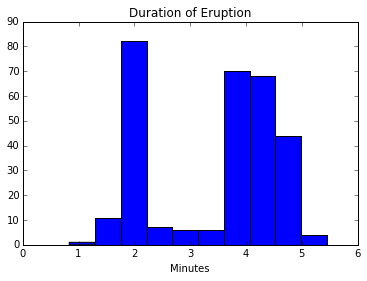

In [2]:
# Bring in the data:
import statsmodels.api as sm
from time import time
import pylab as plt
import numpy as np
import csv

# Load the data I want to use:
print "Load Geyser data exported from R's MASS public data libraries"
with open("./old_faithful_MASS_data.csv", 'rb') as filehandle:
    csv_reader = csv.reader(filehandle)
    header = csv_reader.next()   # Pull off the header
    old_faithful = []
    for row in csv_reader:
        old_faithful.append([float(x) for x in row])

geyser_data = zip(*old_faithful)
# Now have the data all together.

# Get number of observations:
N = len(geyser_data[0])

# Set up a column vector of y-values:
Y = np.array( [ geyser_data[header.index('duration')] ] ).T

# Set up matrix of X-values:
X = np.array( [ [1.0]*N, geyser_data[header.index('waiting')] ] ).T

print "Scatterplot of duration and waiting:"
plt.scatter(x=X[:,1], y=Y, s=20, c=u'b', marker=u'o')
plt.title("Waiting Time for Eruption vs.\nDuration of Subsequent Eruption")
plt.xlabel("Waiting time, minutes")
plt.ylabel("Duration, minutes")
plt.show()

print "\Histograms of duration and waiting:"
plt.hist(x=X[:,1], label="Waiting Times")
plt.title("Waiting Time for Eruption")
plt.xlabel("Minutes")
plt.show()

plt.hist(x=Y, label="Duration of Eruption")
plt.title("Duration of Eruption")
plt.xlabel("Minutes")
plt.show()

In [3]:
# --------------------------------------------------------------------------
# ------------ Run regression and bootstrap in single core mode ------------
# --------------------------------------------------------------------------

print "Running regression and bootstrap in single core mode, using previously \
defined 'run_regression' and 'single_bootstrap' functions."

N_boots = 100000
seed_seed = 123456

print "Step 1: Run the regression"
Beta_hat = run_regression(X,Y)

# Set up random number generation for bootstrap variance estimate
seed_RNG = np.random.RandomState(seed_seed)
parallel_seeds = seed_RNG.randint(0,2**30,size=N_boots)

print "Step 2: Run the bootstrap using map and previously-defined functions"
mapped_bootstrap = lambda seed, X=X,Y=Y:  single_bootstrap(X=X,Y=Y,seed=seed)
t0 = time()
results = map(mapped_bootstrap, parallel_seeds)
t1 = time()

# Pull out important values:
beta_std = np.array([ [np.std(z) for z in zip(*results)] ]).T

# Print results:
print "\n\nFinished funning single-core regression with bootstrap. Time and results as follows:"
single_core_bootstrap_time = (t1-t0)/60.0
print "\nTime: ", single_core_bootstrap_time, "min\nResults are: \nbeta:",Beta_hat, "\nbeta_std:", beta_std


# --------------------------------------------------------------------------
# --------------- Run basic OLS regression from Statsmodels  ---------------
# --------------------------------------------------------------------------

print "Now running regression using standard OLS methods and asymptotic \
variance as estimated by Python library statsmodels."

# Now run the same thing using statsmodels:
reg = sm.OLS(Y,X)
estimation = reg.fit()
print "Regression fit results from statsmodels:\n",estimation.summary2()


Running regression and bootstrap in single core mode, using previously defined 'run_regression' and 'single_bootstrap' functions.
Step 1: Run the regression
Step 2: Run the bootstrap using map and previously-defined functions


Finished funning single-core regression with bootstrap. Time and results as follows:

Time:  0.210494414965 min
Results are: 
beta: [[ 7.31314434]
 [-0.05327198]] 
beta_std: [[ 0.26918934]
 [ 0.00365877]]
Now running regression using standard OLS methods and asymptotic variance as estimated by Python library statsmodels.
Regression fit results from statsmodels:
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.414   
Dependent Variable: y                AIC:                773.4277
Date:               2016-02-25 21:35 BIC:                780.8286
No. Observations:   299              Log-Likelihood:     -384.71 
Df Model:           1                F-statistic:        211.2   
Df Residuals:       297      

Note that the results from the OLS regression essentially match those of the bootstrap:


|           | Manual + Bootstrap | statsmodels     |
| --------- | ------------------ | --------------- |
| $\hat{\beta}$   | 7.3131,  -0.0533   | 7.3131, -0.0533 |
| $\hat{\sigma}$  | 0.2692,   0.0037  | 0.2699, 0.0037  |



## Run Spark Bootstrap Regression, Compare to Single-Core Bootstrap

The core mechanism of Spark is the Resilient Distributed Dataset, or RDD. This is an extremely flexible datatype which can be effortlessly stored on a distributed filesystem such as Hadoop HDFS. 

The key danger in a distributed filesystem is that one node (eg. the  of the system might fail, and when that occurs the final product of the distributed computation is corrupted because an unknown core section of the computation is left undone. Stated differently, a single hard drive may have a very small chance of failure -- 0.01% per year, perhaps. However as the number of independent drives increases, the probability that *at least one drive will fail* increases. 

If one drive failure implies that the entire distributed computation fails, then the probability of total project failure increases as additional nodes are added. 

Successful distributed systems (such as the Hadoop filesystem, HDFS) opperate by replicating enough of the information contained in each node across multiple nodes. If a single node fails, the entire distributed computation is not lost because the non-failing nodes can detect the failure and replicate the lost work. The amount of replication of data and computation across nodes can be selected such that the probability of total project failure is constrained to acceptable levels. 

The Resilient Distributed Dataset, or RDD, is Spark's implemenation of the above-described approach to distributed computation. The RDD is distributed across multiple nodes and opperations on the RDD are automatically distributed as well. The implemenation of changes to the RDD are executed in such a way that the full set of operations can be reconstructed at any time, to address problems with 



There are a handful of general programming frameworks which have been formulated to address this, but often these systems temselves make it relatively difficult to write programs for distributed computation. 


One of the costs of this distribution of data and computation is added difficulty in writing programs for distributed computation. Another is that the distributed 



How does this matter for the Resilient Distributed Datasets, or RDDs?



such that lost work due to a node failure can be done by other nodes 

lost work due to  such that a single node failure




The name comes from the fact that the datatype will manage itself across multiple machines -- 

In [4]:
# *NOW* the Q: can we run this quickly across all cores using pyspark?
from pyspark import SparkContext

try:
    sc = SparkContext("local", appName="Basic-Bootstrap-OLS")   # Need to leave this out when
except:
    pass

# 
rdd_bootseeds = sc.parallelize([xseed for xseed in parallel_seeds])
# rdd_bootseeds = sc.parallelize([xseed for xseed in parallel_seeds])

# Define the massive function which will be sent across all the seeds:
# NOTE that have bound the data values.
mapped_bootstrap = lambda seed, X=X,Y=Y:  single_bootstrap(X=X,Y=Y,seed=seed)

trdd0 = time()
resultsRDD = rdd_bootseeds.map(mapped_bootstrap).collect()
trdd1 = time()

# .... and now look at the resultsRDD

# pull out the values:
#beta_std = np.array([ [np.std(z) for z in zip(*results)] ]).T

RDD_bootstrap_time = (trdd1-trdd0)/60.0
print "\nTime to Spark bootstrap: ", RDD_bootstrap_time, "min\n"

# pull out the values:
spark_beta_std = np.array([ [np.std(z) for z in zip(*resultsRDD)] ]).T

print "Results are: \nbeta:",Beta_hat, "\nsingle-core beta_std:", beta_std, "\nmulti-core beta_std:", spark_beta_std



Time to Spark bootstrap:  0.168466850122 min

Results are: 
beta: [[ 7.31314434]
 [-0.05327198]] 
single-core beta_std: [[ 0.26918934]
 [ 0.00365877]] 
multi-core beta_std: [[ 0.26918934]
 [ 0.00365877]]
